# 논문 리뷰

기존 GAN의 생성모델의 input은 z 하나 였지만 InfoGAN은 (z,c)로 code 라는 latent variable c 를 추가했다.  
또한 GAN의 objective을 수정하여 생성모델이 학습을 할 때 코드 c와 생성된 샘플 사이의 Mutual Information이 높아지도록 도와준다.

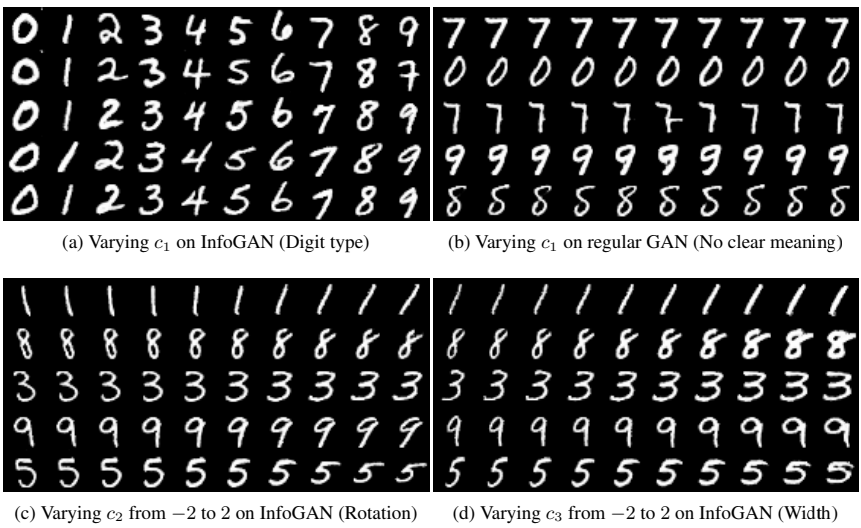

InfoGAN으로 학습시킨 code에 약간씩 변화를 주며 숫자 종류, 회전, 너비를 학습한 모습을 볼 수 있다.  
  
숫자 종류(0~9)의 변동을 포착하는 discrete latent variable  
회전 변동을 포착하는 continuous latent variable  
너비 변동을 포착하는 continuous latent variable  
이렇게 세가지 변동인지를 각각 학습하고 싶은 것  

이처럼 InfoGAN에서는 생성모델이 회전과 같은 의미를 이해하고 이에 해당하는 code를 학습할 수 있도록 기존 GAN에 Mutual Information을 이용하여 학습시킨다.

기존 목적함수

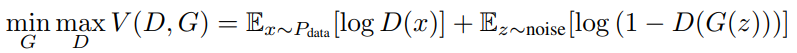

InfoGAN의 목적함수

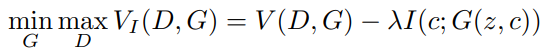

$ I(c;G(z,c)) $는 latent code $c$ 와 생성자의 분포 $G(z,c)$간에 상호정보를 의미한다.  
우리는 $x$ ~ $G(z,c)$ 에 대해 $P(x|c)$가 작은 엔트로피를 갖게 해야한다.  
즉 $ I(c;G(z,c)) $이 최대화 되는 방향으로 $G$가 학습되도록 한다.

이때 $ I(c;G(z,c)) $는 우리가 알지 못하는 c에 대한 $P(c|x)$의 계산을 요구하므로 직접 구하기 어렵다.  
대신 $P(c|x)$를 근사하는 보조분포 $Q(c|x)$를 활용하여 상호정보에 대한 Variational Lower Bound를 구해 간접적으로 최적화 할 수 있다.

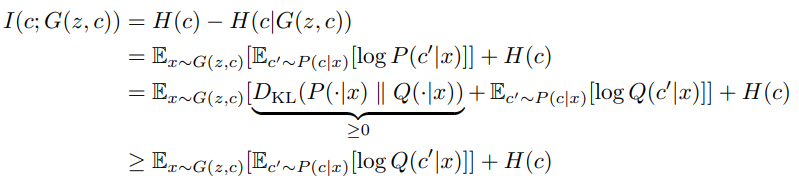

즉 $ I(c;G(z,c)) $의 최대화가 어려우니 이것의 하한인 $ L_I(G,Q) $를 최대화한다. 위의 식에는 여전히 $ c' $~$ P(c|x) $이 있어 아래의 과정을 적용한다.

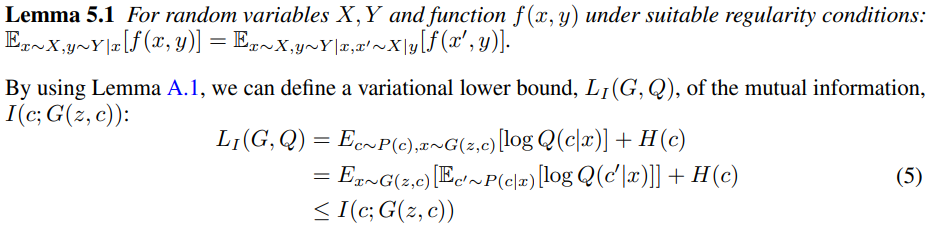

$L_I(G,Q)$에서는 $Q$를 직접적으로 최대화 될 수 있고, $G$는 reparametrization trick을 사용하여 최대화될 수 있어 기존 GAN의 훈련프로세스의 변경없이 Objective에 추가될 수 있다.

이렇게 유도된 알고리즘을 Information Maximizing Generative Adversarial Networks라 부르며 목적함수는 아래와 같다.

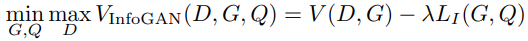

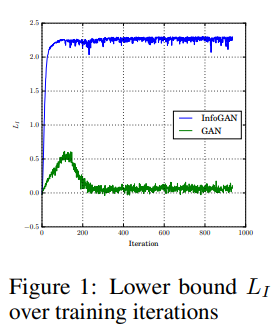

latent code $c$와 생성된 샘플 $G(z,c)$간의 상호정보가 정말 잘 최대화 되는지 확인  

MNIST를 이용했고 $c$는 10개의 class를 갖는 discrete unifrom 분포를 가정

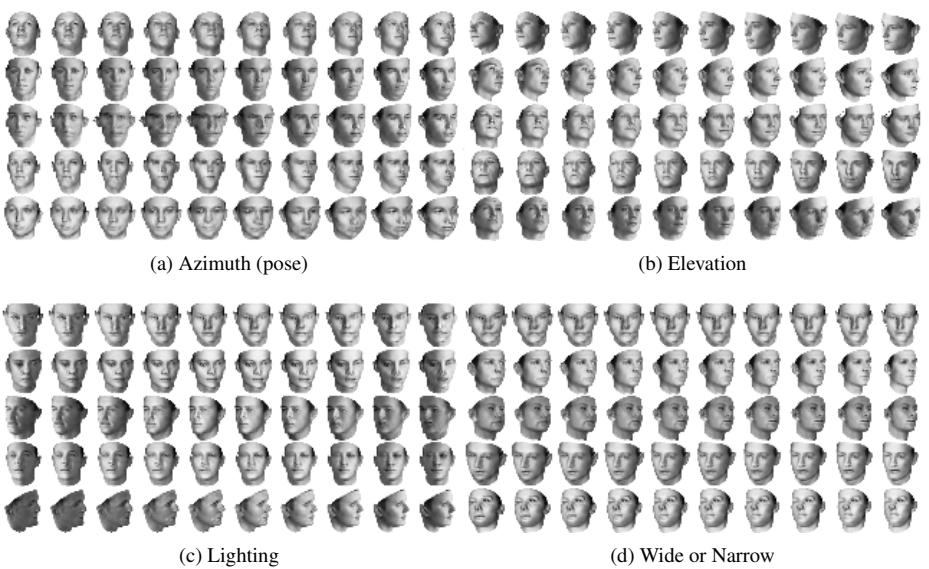

$c_i$ ~ $Unif(-1,1) $ , $ i=1,2,...,5$로 연속형 잠재변수를 설정  

순서대로 얼굴각도, 시선, 명암, 얼굴의 너비 등의 변동에 대해서 잘 학습되었음

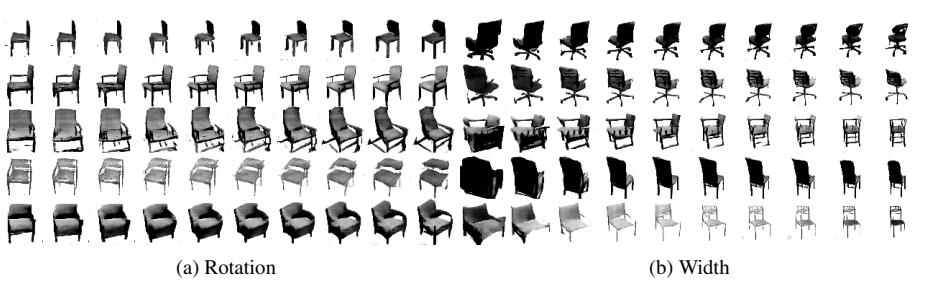

여기서도 회전과 너비에 관해서 모델이 잘 학습했음

# 실습

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as dsets

transform = transforms.Compose([
            transforms.Resize(28),
            transforms.CenterCrop(28),
            transforms.ToTensor()])
dataloader = dsets.MNIST('./dataset', train='train',
                                download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset=dataloader, batch_size=128,
                                         shuffle=True, num_workers=4)
import torch
import torch.nn as nn
import torch.nn.functional as F

"""
Architecture based on InfoGAN paper.
"""

class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.tconv1 = nn.ConvTranspose2d(74, 1024, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(1024)

        self.tconv2 = nn.ConvTranspose2d(1024, 128, 7, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)

        self.tconv3 = nn.ConvTranspose2d(128, 64, 4, 2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)

        self.tconv4 = nn.ConvTranspose2d(64, 1, 4, 2, padding=1, bias=False)

    def forward(self, x):
        x = F.relu(self.bn1(self.tconv1(x)))
        x = F.relu(self.bn2(self.tconv2(x)))
        x = F.relu(self.bn3(self.tconv3(x)))

        img = torch.sigmoid(self.tconv4(x))

        return img

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 64, 4, 2, 1)

        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 1024, 7, bias=False)
        self.bn3 = nn.BatchNorm2d(1024)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.1, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.1, inplace=True)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.1, inplace=True)

        return x

class DHead(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Conv2d(1024, 1, 1)

    def forward(self, x):
        output = torch.sigmoid(self.conv(x))

        return output

class QHead(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1024, 128, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(128)

        self.conv_disc = nn.Conv2d(128, 10, 1)
        self.conv_mu = nn.Conv2d(128, 2, 1)
        self.conv_var = nn.Conv2d(128, 2, 1)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.1, inplace=True)

        disc_logits = self.conv_disc(x).squeeze()

        mu = self.conv_mu(x).squeeze()
        var = torch.exp(self.conv_var(x).squeeze())

        return disc_logits, mu, var
def weights_init(m):
    """
    Initialise weights of the model.
    """
    if(type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif(type(m) == nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class NormalNLLLoss:
    """
    Calculate the negative log likelihood
    of normal distribution.
    This needs to be minimised.
    Treating Q(cj | x) as a factored Gaussian.
    """
    def __call__(self, x, mu, var):

        logli = -0.5 * (var.mul(2 * np.pi) + 1e-6).log() - (x - mu).pow(2).div(var.mul(2.0) + 1e-6)
        nll = -(logli.sum(1).mean())

        return nll

def noise_sample(n_dis_c, dis_c_dim, n_con_c, n_z, batch_size, device):
    """
    Sample random noise vector for training.
    INPUT
    --------
    n_dis_c : Number of discrete latent code.
    dis_c_dim : Dimension of discrete latent code.
    n_con_c : Number of continuous latent code.
    n_z : Dimension of iicompressible noise.
    batch_size : Batch Size
    device : GPU/CPU
    """

    z = torch.randn(batch_size, n_z, 1, 1, device=device)

    idx = np.zeros((n_dis_c, batch_size))
    if(n_dis_c != 0):
        dis_c = torch.zeros(batch_size, n_dis_c, dis_c_dim, device=device)

        for i in range(n_dis_c):
            idx[i] = np.random.randint(dis_c_dim, size=batch_size)
            dis_c[torch.arange(0, batch_size), i, idx[i]] = 1.0

        dis_c = dis_c.view(batch_size, -1, 1, 1)

    if(n_con_c != 0):
        # Random uniform between -1 and 1.
        con_c = torch.rand(batch_size, n_con_c, 1, 1, device=device) * 2 - 1

    noise = z
    if(n_dis_c != 0):
        noise = torch.cat((z, dis_c), dim=1)
    if(n_con_c != 0):
        noise = torch.cat((noise, con_c), dim=1)

    return noise, idx
params = {
    'batch_size': 128,# Batch size.
    'num_epochs': 100,# Number of epochs to train for.
    'learning_rate': 2e-4,# Learning rate.
    'beta1': 0.5,
    'beta2': 0.999,
    'save_epoch' : 25,# After how many epochs to save checkpoints and generate test output.
    'dataset' : 'MNIST'}

if(params['dataset'] == 'MNIST'):
    params['num_z'] = 62
    params['num_dis_c'] = 1
    params['dis_c_dim'] = 10
    params['num_con_c'] = 2

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import torch.optim as optim
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import random

device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")

netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

discriminator = Discriminator().to(device)
discriminator.apply(weights_init)
print(discriminator)

netD = DHead().to(device)
netD.apply(weights_init)
print(netD)

netQ = QHead().to(device)
netQ.apply(weights_init)
print(netQ)

# Loss for discrimination between real and fake images.
criterionD = nn.BCELoss()
# Loss for discrete latent code.
criterionQ_dis = nn.CrossEntropyLoss()
# Loss for continuous latent code.
criterionQ_con = NormalNLLLoss()

# Adam optimiser is used.
optimD = optim.Adam([{'params': discriminator.parameters()}, {'params': netD.parameters()}], lr=params['learning_rate'], betas=(params['beta1'], params['beta2']))
optimG = optim.Adam([{'params': netG.parameters()}, {'params': netQ.parameters()}], lr=params['learning_rate'], betas=(params['beta1'], params['beta2']))

# Fixed Noise
z = torch.randn(100, params['num_z'], 1, 1, device=device)
fixed_noise = z
if(params['num_dis_c'] != 0):
    idx = np.arange(params['dis_c_dim']).repeat(10)
    dis_c = torch.zeros(100, params['num_dis_c'], params['dis_c_dim'], device=device)
    for i in range(params['num_dis_c']):
        dis_c[torch.arange(0, 100), i, idx] = 1.0

    dis_c = dis_c.view(100, -1, 1, 1)

    fixed_noise = torch.cat((fixed_noise, dis_c), dim=1)

if(params['num_con_c'] != 0):
    con_c = torch.rand(100, params['num_con_c'], 1, 1, device=device) * 2 - 1
    fixed_noise = torch.cat((fixed_noise, con_c), dim=1)

real_label = 1.0
fake_label = 0.0

# List variables to store results pf training.
img_list = []
G_losses = []
D_losses = []

print("-"*25)
print("Starting Training Loop...\n")
print('Epochs: %d\nDataset: {}\nBatch Size: %d\nLength of Data Loader: %d'.format(params['dataset']) % (params['num_epochs'], params['batch_size'], len(dataloader)))
print("-"*25)

start_time = time.time()
iters = 0
for epoch in range(params['num_epochs']):
    epoch_start_time = time.time()

    for i, (data, _) in enumerate(dataloader, 0):
        # Get batch size
        b_size = data.size(0)
        # Transfer data tensor to GPU/CPU (device)
        real_data = data.to(device)


        # Updating discriminator and DHead
        optimD.zero_grad()
        # Real data
        label = torch.full((b_size, ), real_label, device=device)
        output1 = discriminator(real_data)
        probs_real = netD(output1).view(-1)
        loss_real = criterionD(probs_real, label)
        # Calculate gradients.
        loss_real.backward()

        # Fake data
        label.fill_(fake_label)
        noise, idx = noise_sample(params['num_dis_c'], params['dis_c_dim'], params['num_con_c'], params['num_z'], b_size, device)
        fake_data = netG(noise)
        output2 = discriminator(fake_data.detach())
        probs_fake = netD(output2).view(-1)
        loss_fake = criterionD(probs_fake, label)
        # Calculate gradients.
        loss_fake.backward()

        # Net Loss for the discriminator
        D_loss = loss_real + loss_fake
        # Update parameters
        optimD.step()

        # Updating Generator and QHead
        optimG.zero_grad()

        # Fake data treated as real.
        output = discriminator(fake_data)
        label.fill_(real_label)
        probs_fake = netD(output).view(-1)
        gen_loss = criterionD(probs_fake, label)

        q_logits, q_mu, q_var = netQ(output)
        target = torch.LongTensor(idx).to(device)
        # Calculating loss for discrete latent code.
        dis_loss = 0
        for j in range(params['num_dis_c']):
            dis_loss += criterionQ_dis(q_logits[:, j*10 : j*10 + 10], target[j])

        # Calculating loss for continuous latent code.
        con_loss = 0
        if (params['num_con_c'] != 0):
            con_loss = criterionQ_con(noise[:, params['num_z']+ params['num_dis_c']*params['dis_c_dim'] : ].view(-1, params['num_con_c']), q_mu, q_var)*0.1

        # Net loss for generator.
        G_loss = gen_loss + dis_loss + con_loss
        # Calculate gradients.
        G_loss.backward()
        # Update parameters.
        optimG.step()

        # Check progress of training.
        if i != 0 and i%100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch+1, params['num_epochs'], i, len(dataloader),
                    D_loss.item(), G_loss.item()))

        # Save the losses for plotting.
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

        iters += 1

    epoch_time = time.time() - epoch_start_time
    print("Time taken for Epoch %d: %.2fs" %(epoch + 1, epoch_time))
    # Generate image after each epoch to check performance of the generator. Used for creating animated gif later.
    with torch.no_grad():
        gen_data = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True))

    # Generate image to check performance of generator.
    if((epoch+1) == 1 or (epoch+1) == params['num_epochs']/2):
        with torch.no_grad():
            gen_data = netG(fixed_noise).detach().cpu()
        plt.figure(figsize=(10, 10))
        plt.axis("off")
        plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
        plt.savefig("Epoch_%d {}".format(params['dataset']) %(epoch+1))
        plt.close('all')

training_time = time.time() - start_time
print("-"*50)
print('Training finished!\nTotal Time for Training: %.2fm' %(training_time / 60))
print("-"*50)


Generator(
  (tconv1): ConvTranspose2d(74, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(1024, 128, kernel_size=(7, 7), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)
Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 1024, kernel_size=(7, 7), stride=(1, 1), bias=False)
 

In [ ]:
# Save network weights.
torch.save({
    'netG' : netG.state_dict(),
    'discriminator' : discriminator.state_dict(),
    'netD' : netD.state_dict(),
    'netQ' : netQ.state_dict(),
    'optimD' : optimD.state_dict(),
    'optimG' : optimG.state_dict(),
    'params' : params
    }, 'checkpoint/infoGAN_final!!_{}'.format(params['dataset']))

In [ ]:
# Generate image to check performance of trained generator.
with torch.no_grad():
    gen_data = netG(fixed_noise).detach().cpu()
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
plt.savefig("Epoch_%d_{}".format(params['dataset']) %(params['num_epochs']))
